In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [3]:
sini = 0.5
g1 = 0.05
g2 = 0.0

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=g2)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.23450413223140495
slitAng_major_p: 0.0
slitAng_minor_p: 90.0


In [4]:
#TF_pars = load_pickle("/Users/hhg/Research/kinematic_lensing/data/TF_pars.pickle")
#meta_parameters = ("/Users/hhg/Research/kinematic_lensing/data/meta_parameters.pickle")

#data = load_pickle("/Users/hhg/Research/kinematic_lensing/data/data.pickle")
#noise = load_pickle("/Users/hhg/Research/kinematic_lensing/data/noise.pickle")
#obslambda = np.load("/Users/hhg/Research/kinematic_lensing/data/obslambda.npy")


update_TF, _ = get_TFcube_pars()

update_TF['slitAngles'] = np.array([slitAng_major_p])

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185# 0.1185  # 0.032 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)


# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    data_info['data_list'] = data['spectra']
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 7.24 s, sys: 132 ms, total: 7.37 s
Wall time: 6.02 s


# Image Fit

In [5]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ImageFit.py
ImageFit = ImageFit(data_info=data_info)

# check : data model consistency 
model_image = ImageFit.model_image(e_obs=1, half_light_radius=0.5)

print("data signal", ImageFit.image[63,63])
print("model signal", model_image[63,63])

chainImage_info = ImageFit.run_MCMC(Nwalker=50, Nsteps=1000)

Chain_Image = ChainTool(chainImage_info, Nburn=30000, Nend=50000)

data signal 0.012498768
model signal 0.00983775


100%|██████████| 1000/1000 [00:49<00:00, 20.04it/s]

Total MCMC time (mins): 0.8325743158658345


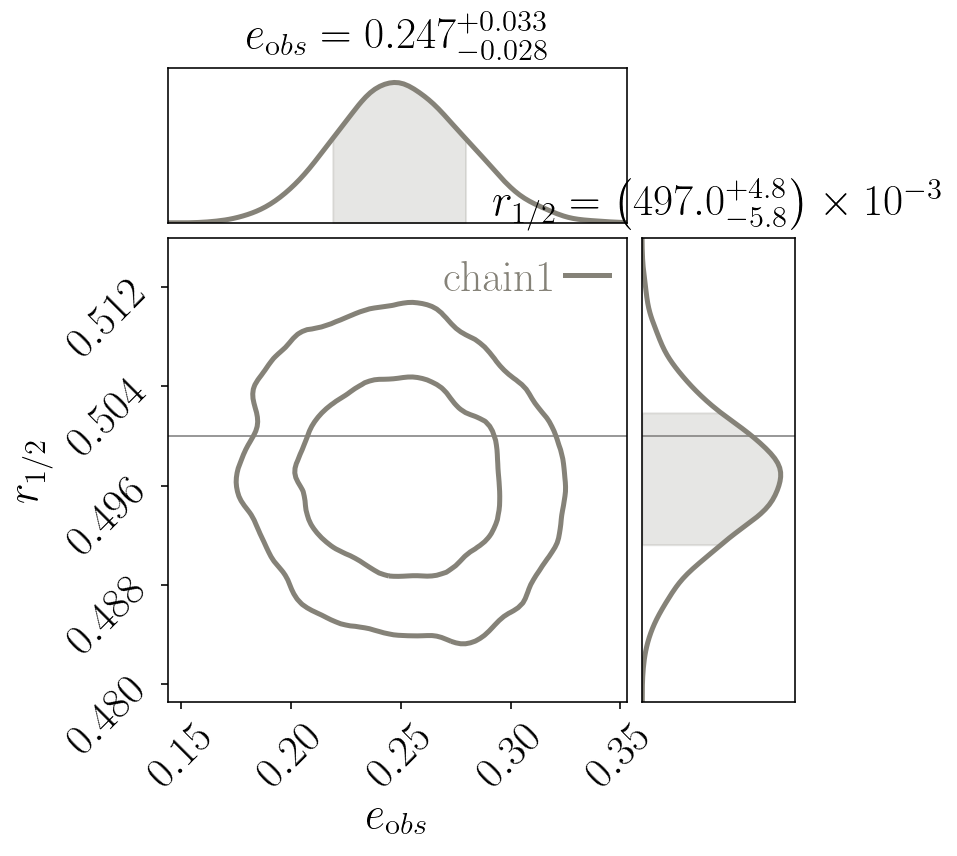

In [6]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','half_light_radius']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=[None,0.5]) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

# 2D spec fit

In [7]:
# init Fit tool
RotFit = RotationCurveFit(data_info, active_par_key = ['r_0', 'v_spec', 'v_0', 'vscale']) #

params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda, par_init_guess={'vscale':0.5})
print(params_rot)

time cost in gaussFit_spec2D: 0.1599898338317871 (secs)
{'vscale': 0.49934036177714985, 'r_0': -0.02959785715942973, 'v_spec': 100.02513223811306, 'v_0': 0.011013264814173111, 'redshift': 0.1999999998026852}


In [8]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

100%|██████████| 3000/3000 [00:09<00:00, 301.25it/s]

Total MCMC time (mins): 0.16613740126291912


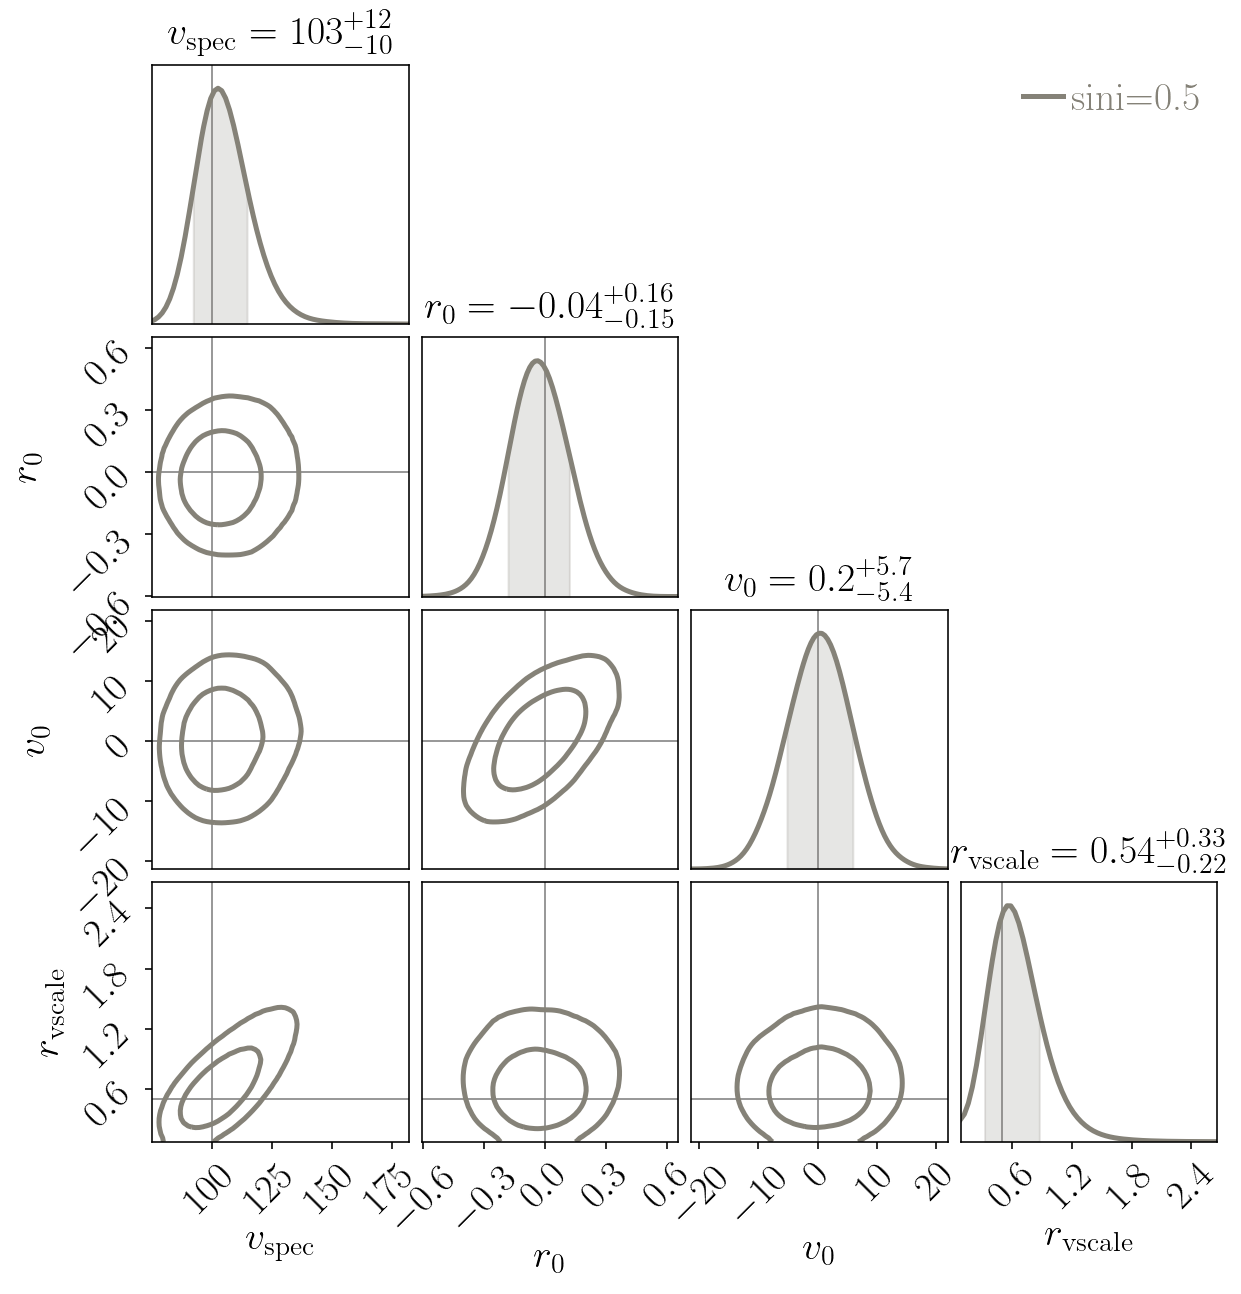

In [9]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['v_spec', 'r_0', 'v_0', 'vscale'] #, 'vscale'
legend_chain = "sini=%.1f"%sini

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

# Start

In [10]:
chain_v_spec = Chain.chain[:, 1]
chain_e_obs = Chain_Image.chain[:, 0]

In [11]:
e_int_fid = cal_e_int(sini=sini, q_z=0.2)
e_obs_fid = cal_e_obs(e_int=e_int_fid, gamma_p=g1)
v_spec_major_fid = TF_pars['vcirc']*TF_pars['sini']

par_fid = {'gamma_p':TF_pars['g1'], 'gamma_x':TF_pars['g2'], 'sini':TF_pars['sini'], 
           'v_TF':200., 'e_obs': e_obs_fid, 'e_int': e_int_fid, 
           'v_spec_major':v_spec_major_fid,
           'v_spec_minor':0.
          }

In [12]:
par_fid

{'gamma_p': 0.05,
 'gamma_x': 0.0,
 'sini': 0.5,
 'v_TF': 200.0,
 'e_obs': 0.23450413223140495,
 'e_int': 0.13636363636363635,
 'v_spec_major': 100.0,
 'v_spec_minor': 0.0}

In [110]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/gamma.py

Gamma = Gamma(e_obs=chain_e_obs, v_spec_major=chain_v_spec, par_fid=par_fid, 
              v_spec_minor=None, sigma_TF_intr=0.08)

In [112]:
chainGamma_info = Gamma.run_MCMC(Nwalker=100, Nsteps=1000)

100%|██████████| 1000/1000 [04:14<00:00,  3.93it/s]

Total MCMC time (mins): 4.24185186624527


In [116]:
ChainGamma = ChainTool(chainGamma_info, Nburn=50000, Nend=100000)

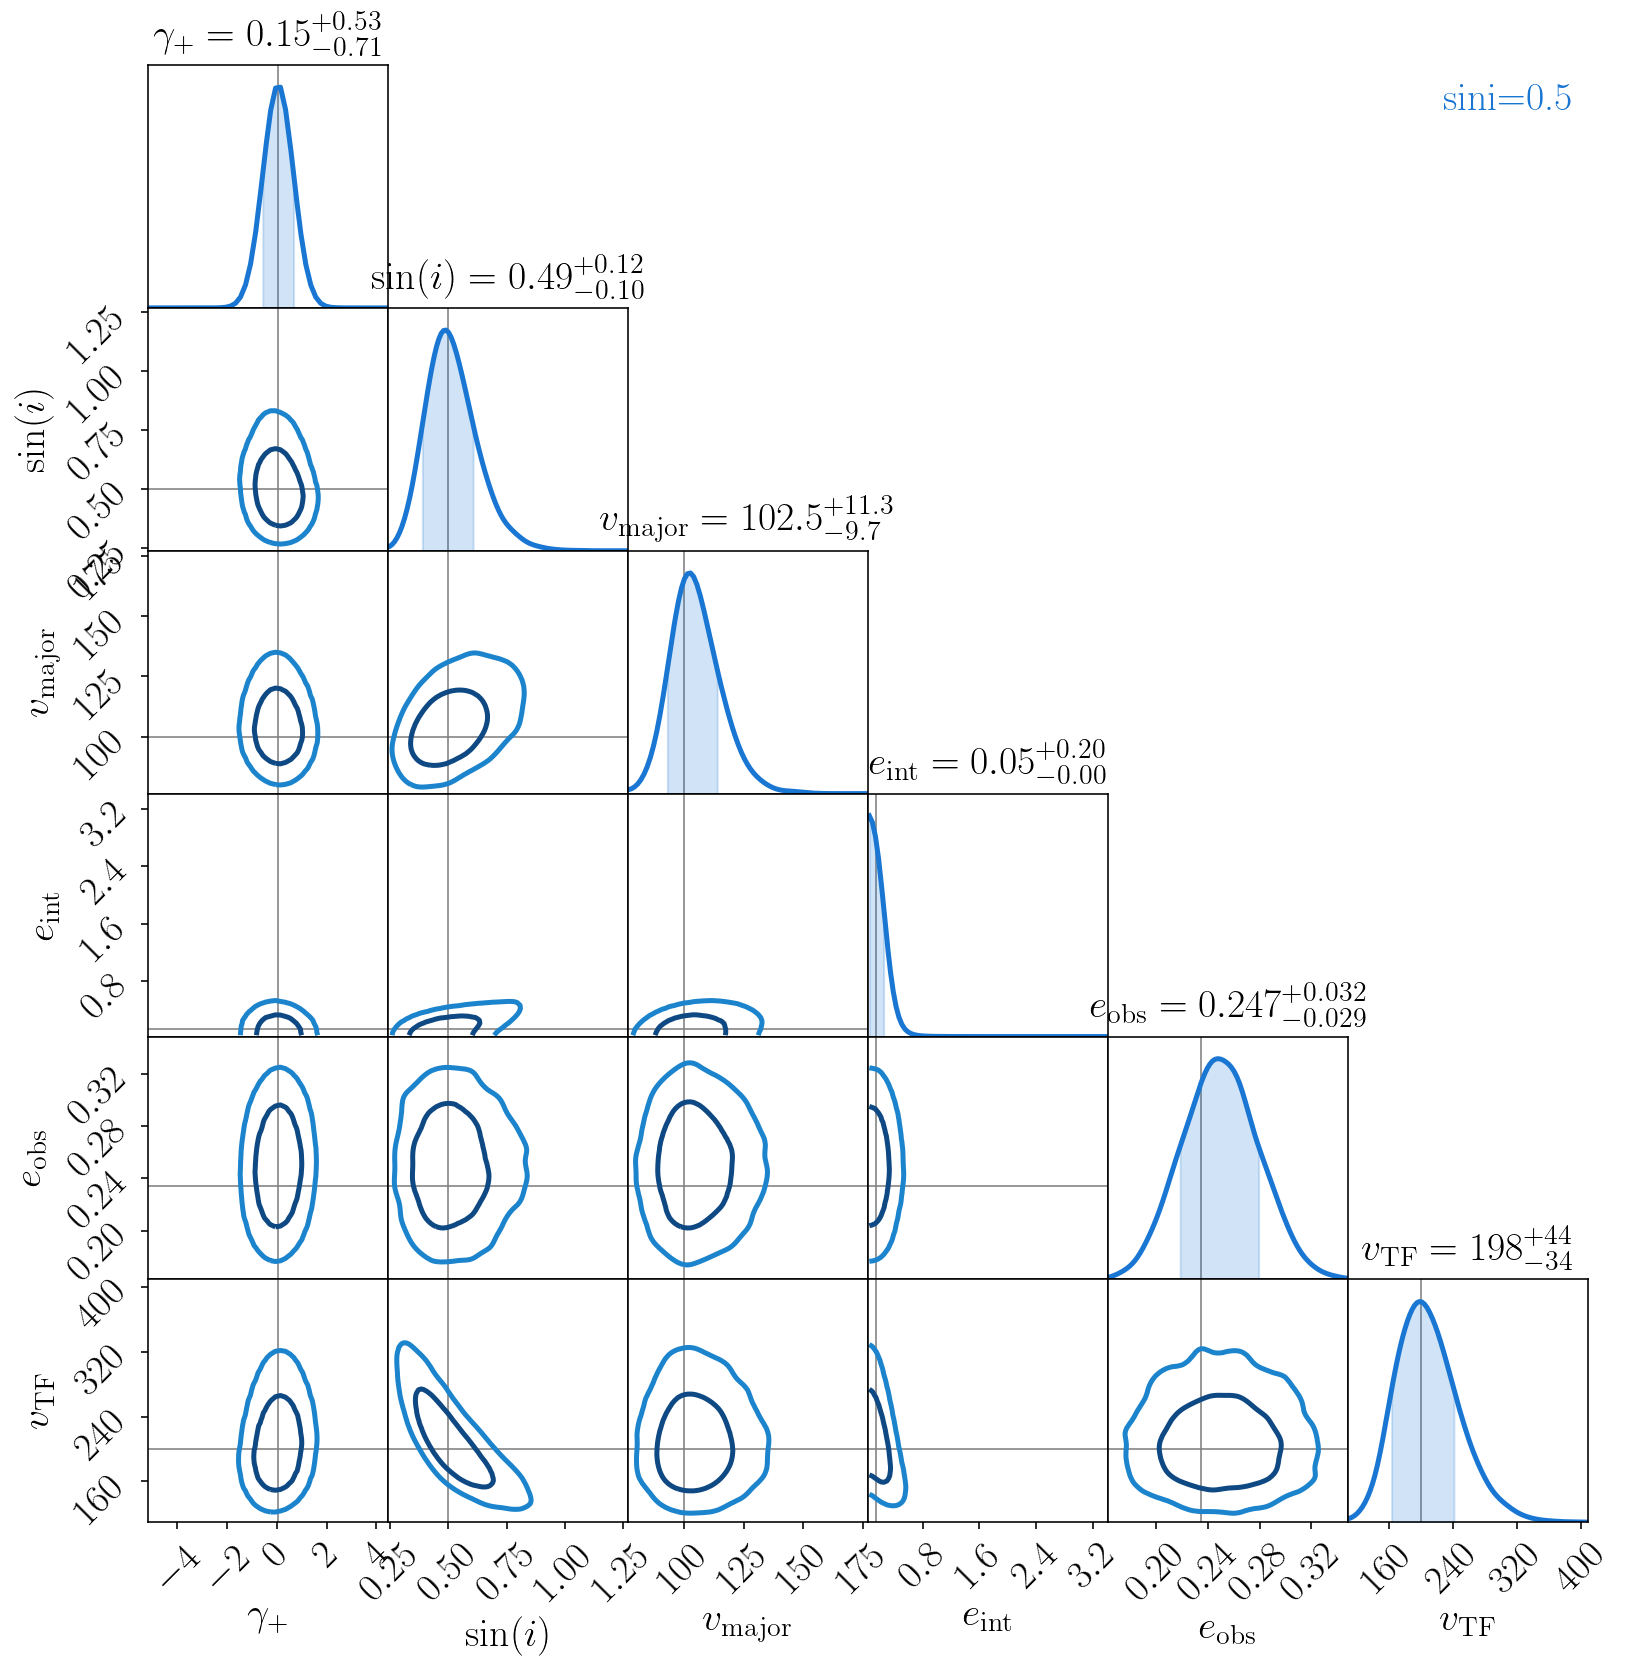

In [125]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['gamma_p', 'sini', 'v_spec_major', 'e_int', 'e_obs', 'v_TF'] 
legend_chain = "sini=%.1f"%sini

parID1,parName1,par_x1 = ChainGamma.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(ChainGamma.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20,
            shade=[False]*Nchains,s
            tatistics=statistics,summary=True)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

# ====== End demo ======

In [29]:
cols=['e_obs', 'v_spec_major', 'v_TF', 'v_spec_minor']
ac=[par_fid[c] for c in cols]
%time Gamma.cal_loglike(ac)

CPU times: user 20.5 ms, sys: 1.63 ms, total: 22.1 ms
Wall time: 3.23 ms


(array([-0.70309882]), 0.5, 0.13636363636363635, 0.05)

In [31]:
??Gamma.kde_v_spec_major.logpdf

In [24]:
%timeit Gamma.kde_v_spec_major.logpdf(x=par_fid['v_spec_major'])

1.86 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
%timeit Gamma.kde_e_obs.logpdf(x=par_fid['e_obs'])

379 µs ± 6.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
%timeit Gamma.logPrior_v_TF(v_TF=par_fid['v_TF'])

5.06 µs ± 47.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Check the performance of kde fit

In [33]:
from scipy.stats import gaussian_kde

In [34]:
kde_v_spec = gaussian_kde(chain_v_spec.T, bw_method=None)
kde_e_obs = gaussian_kde(chain_e_obs.T, bw_method=None)

In [37]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gray']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


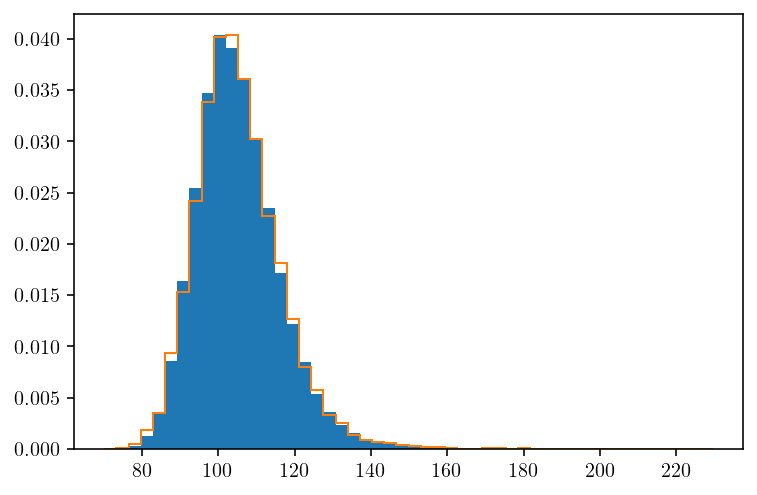

In [38]:
# check the resample method

resample_v_spec = kde_v_spec.resample(10000).T

p, e, f = hist(chain_v_spec,density=True,bins=50)
_ = hist(resample_v_spec, density=True, bins= e, histtype='step')

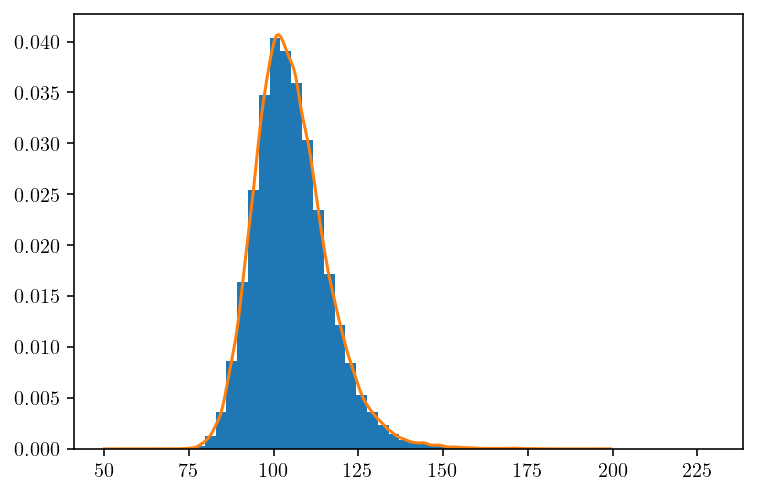

In [93]:
# check the pdf method
v_tick = np.arange(50, 200, step=0.5)
pdf_v_spec = kde_v_spec.pdf(x=v_tick)

p, e, f = hist(chain_v_spec,density=True,bins=50)
plot(v_tick, pdf_v_spec)
#yscale('log')
#ylim(0.00001,1)

In [50]:
from scipy.interpolate import interp1d

In [52]:
em=.5*(e[1:]+e[:-1])

In [65]:
pi=interp1d(em,log(p),bounds_error=False,fill_value=0)
%time pi(100)

CPU times: user 67 µs, sys: 9 µs, total: 76 µs
Wall time: 69.9 µs


/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array(-3.2291039)

In [105]:
%time kde_v_spec.logpdf(x=-1000.)

CPU times: user 48.4 ms, sys: 1.7 ms, total: 50.1 ms
Wall time: 6.14 ms


array([-559078.44787728])

In [44]:
%time kde_v_spec.pdf(x=-1000.)

CPU times: user 52.3 ms, sys: 3.86 ms, total: 56.1 ms
Wall time: 7.46 ms


array([0.])